# Analysing text similarity using spaCy, networkX 

This notebook demonstrates one way of using spaCy to conduct a rapid thematic analysis of a small corpus of comments, and introduces some unusual network visualisations.
Topics include: 
* [spaCy](https://spacy.io/) - an open source NLP library, 
* word vectors, and
* networkX - an open source network (graph) analysis and visualisation library. 

The notebook is partly a reminder for myself on just how (well) these techniques work, but I hope that others find it useful. I'll continue to update it with more techniques over the coming weeks.
If you have any suggestions, feel free to make them in the comments, fork the notebook etc. I'm keen to exchange tips and tricks. 


# Plan

* load a representative set of tweets
* demonstrate some basic spaCy features
* test its similarity metrics
* build a graph data structure for storing (n * n-1) / 2 similarity results
* visualise the clusters of most-similar items in the data
* plan the next steps

In [37]:
import pandas as pd
import spacy
import networkx as nx                        # a really useful network analysis library
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
# from networkx.algorithms import community   # not used, yet... 
import datetime                              # access to %%time, for timing individual notebook cells
import os

This next step load the spaCy language model. It generally takes about 13s to load this 'large' model.

In [5]:
#nlp = spacy.load('es_core_news_lg')           # A more detailed model (with higher-dimension word vectors) - 13s to load, normally
nlp = spacy.load('es_core_news_md')           # a smaller model, e.g. for testing

In [6]:
plt.rcParams['figure.figsize'] = [10, 10]  # makes the output plots large enough to be useful

## Data

In [30]:
#rowlimit = 500              # this limits the tweets to a manageable number
year_label= '2018'
data = pd.read_csv(f'df_{year_label}.csv')#, nrows = rowlimit)
data.shape

(1279, 8)

In [31]:
data.head()

,Unnamed: 0,Participante,Texto,Sentimiento,Palabras,Dia,Mes,Anio
0,0,-PRESIDENTE ANDRES MANUEL LOPEZ OBRADOR,Informarles que el día de hoy voy a enviar al...,0.001959,58,6,12,2018
1,1,-PRESIDENTE ANDRES MANUEL LOPEZ OBRADOR,Les doy a conocer los nombres de quienes están...,0.771382,10,6,12,2018
2,2,-PRESIDENTE ANDRES MANUEL LOPEZ OBRADOR,La abogada Loretta Ortiz. Ella es egresada de ...,0.034682,27,6,12,2018
3,3,-PRESIDENTE ANDRES MANUEL LOPEZ OBRADOR,"También, la licenciada Celia Maya García. Ella...",0.003624,46,6,12,2018
4,4,-PRESIDENTE ANDRES MANUEL LOPEZ OBRADOR,Y el tercer abogado propuesto es el licenciado...,0.017006,39,6,12,2018


In [36]:
text_set = set(''.join(data.Texto).split(' '))
len(text_set)

7688

In [48]:
data = pd.DataFrame(text_set)
data[0]

0                  
1            atrás,
2         carácter.
3            venían
4          demandas
           ...     
7683       empresa,
7684    llamándolos
7685     días.David
7686         pienso
7687            ¿Lo
Name: 0, Length: 7688, dtype: object

## Using spaCy to parse the tweets.

N.B. this next step can take a while - e.g. 14 mins, for the full set - but only 5s for 500 rows.

(based on https://stackoverflow.com/questions/44395656/applying-spacy-parser-to-pandas-dataframe-w-multiprocessing)...

In [49]:
tokens = []
lemma = []
pos = []
parsed_doc = [] 
col_to_parse = 0

for doc in nlp.pipe(data[col_to_parse].astype('unicode').values, batch_size=50):
    if doc.has_annotation("DEP"):
        parsed_doc.append(doc)
        tokens.append([n.text for n in doc])
        lemma.append([n.lemma_ for n in doc])
        pos.append([n.pos_ for n in doc])
    else:
        # We want to make sure that the lists of parsed results have the
        # same number of entries of the original Dataframe, so add some blanks in case the parse fails
        tokens.append(None)
        lemma.append(None)
        pos.append(None)


data['parsed_doc'] = parsed_doc
data['comment_tokens'] = tokens
data['comment_lemma'] = lemma
data['pos_pos'] = pos

## Basic checks of the parsed data

In [50]:
data.head(8)

,0,parsed_doc,comment_tokens,comment_lemma,pos_pos
0,,(),[],[],[]
1,"atrás,","(atrás, ,)","[atrás, ,]","[atrás, ,]","[ADV, PUNCT]"
2,carácter.,"(carácter, .)","[carácter, .]","[carácter, .]","[NOUN, PUNCT]"
3,venían,(venían),[venían],[venir],[VERB]
4,demandas,(demandas),[demandas],[demanda],[NOUN]
5,"embargo,","(embargo, ,)","[embargo, ,]","[embargo, ,]","[NOUN, PUNCT]"
6,"Zedillo,","(Zedillo, ,)","[Zedillo, ,]","[Zedillo, ,]","[PROPN, PUNCT]"
7,construiría,(construiría),[construiría],[construir],[VERB]


## Removing stopwords

We could reduce increase the signal:noise ratio in these texts by removing some of the more common words (or *stopwords*). By removing these from the tweets, we would prevent them from influencing the analysis of whether two tweets are similar. I'm not addressing this is the notebook yet, but I will come back to it later. For now, let's just look at what words are included in spaCy's stopword list.

In [51]:
stop_words = set(stopwords.words('spanish'))
print('Number of stopwords: %d' % len(stop_words))
print(list(stop_words))

Number of stopwords: 313
['habiendo', 'me', 'desde', 'porque', 'estuviera', 'estén', 'míos', 'suya', 'quien', 'estos', 'estuviéramos', 'vosotras', 'tuvieses', 'seáis', 'seríais', 'muy', 'tenéis', 'para', 'estabas', 'hubiste', 'fue', 'ella', 'estuvo', 'a', 'estuvieseis', 'seréis', 'la', 'contra', 'seré', 'haya', 'estar', 'suyo', 'estarían', 'vuestro', 'estaréis', 'estuviese', 'estés', 'os', 'estaban', 'todos', 'hubiésemos', 'mucho', 'tuyo', 'habías', 'sentidos', 'este', 'estamos', 'tenidos', 'con', 'tuvo', 'teniendo', 'habría', 'estaría', 'muchos', 'hubieras', 'habré', 'tú', 'sería', 'hubiera', 'somos', 'él', 'entre', 'por', 'estaba', 'he', 'suyas', 'esté', 'tendré', 'sean', 'sentido', 'algo', 'tenías', 'habrá', 'tuvimos', 'cuando', 'ellos', 'tuya', 'seremos', 'tendrían', 'tienen', 'habrán', 'estaríais', 'su', 'en', 'fueron', 'estará', 'era', 'estuve', 'tengo', 'ha', 'y', 'serías', 'habréis', 'hubieseis', 'habrían', 'tuviéramos', 'estuvieran', 'ti', 'tus', 'nada', 'hasta', 'teníamos', '

In [52]:
world_data = data

In [53]:
raw_G = nx.Graph()

In [54]:
# takes 1s for 500 nodes - but of course this won't scale linearly!                              
raw_G = nx.Graph() # undirected
n = 0

for i in world_data['parsed_doc']:        # sure, it's inefficient, but it will do
    for j in world_data['parsed_doc']:
        if i != j:
            if not (raw_G.has_edge(j, i)):
                sim = i.similarity(j)
                raw_G.add_edge(i, j, weight = sim)
                n = n + 1

print(raw_G.number_of_nodes(), "nodes, and", raw_G.number_of_edges(), "edges created.")

/var/folders/v0/vyb8z9hs3b166f_7lmxwvfbr0000gn/T/ipykernel_78402/2906313699.py:9: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  sim = i.similarity(j)


7688 nodes, and 29548828 edges created.


In [55]:
edges_to_kill = []
min_wt = 0.5      # this is our cutoff value for a minimum edge-weight

for n, nbrs in raw_G.adj.items():
    #print("\nProcessing origin-node:", n, "... ")
    for nbr, eattr in nbrs.items():
        # remove edges below a certain weight
        data = eattr['weight']
        if data < min_wt: 
            # print('(%.3f)' % (data))  
            # print('(%d, %d, %.3f)' % (n, nbr, data))  
            #print("\nNode: ", n, "\n <-", data, "-> ", "\nNeighbour: ", nbr)
            edges_to_kill.append((n, nbr)) 
            
print("\n", len(edges_to_kill) / 2, "edges to kill (of", raw_G.number_of_edges(), "), before de-duplicating")


 26999880.0 edges to kill (of 29548828 ), before de-duplicating


In [56]:
for u, v in edges_to_kill:
    if raw_G.has_edge(u, v):   # catches (e.g.) those edges where we've removed them using reverse ... (v, u)
        raw_G.remove_edge(u, v)

In [57]:
strong_G = raw_G
print(strong_G.number_of_edges())

2548948


We should now have a clean graph of only hi-similarity edges.

## Visualising the selected edges

NetworkX has several useful layouts implemented, but you can't beat a good spring-embedding layour (a kind of [force-directed graph](https://en.wikipedia.org/wiki/Force-directed_graph_drawing)).
In graph terminology, what we see is:
* a single large [component](https://en.wikipedia.org/wiki/Connected_component_(graph_theory)) at the centre,
* with several [pendants](https://proofwiki.org/wiki/Definition:Pendant_Vertex) visible at the edges;
* several smaller components; and 
* a peripheral cloud of [isolates](http://mathonline.wikidot.com/isolated-vertices-leaves-and-pendant-edges)

Force-directed graphs are a very intuitive, satisfying, and efficient way to lay out network diagrams. Essentially, every node exerts a repulsive force on every other node. Simultaneously, every connected pair of nodes attract each other. The layout algorithm iterates, finding a layout that balances these forces.

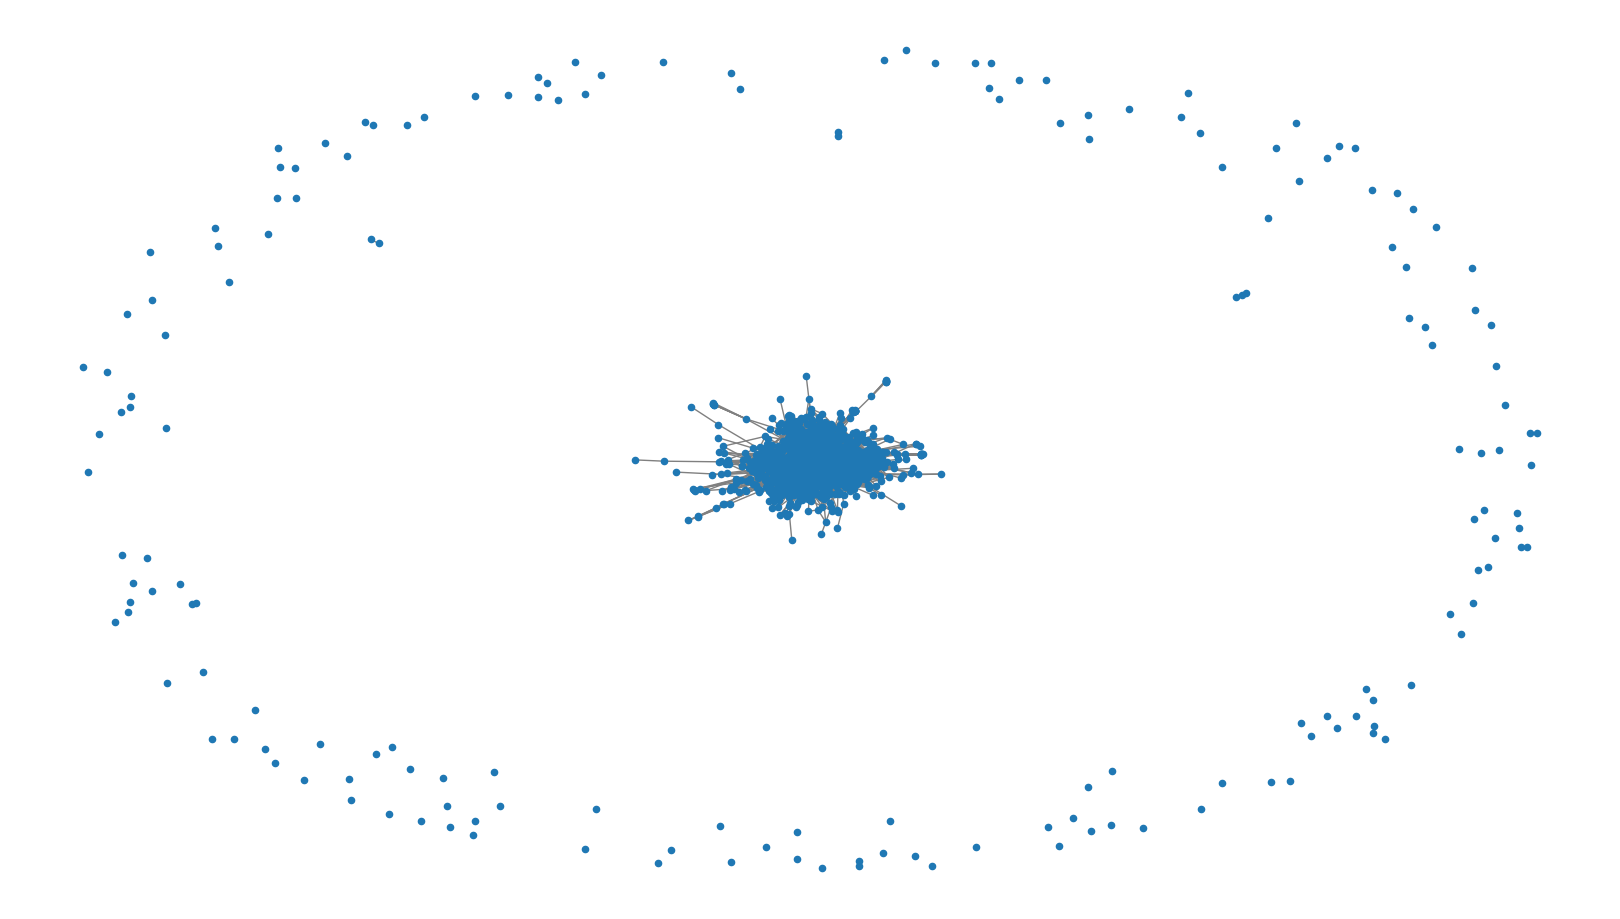

In [58]:
nx.draw(strong_G, node_size=20, edge_color='gray')

Visualising the whole graph, but only those links of weights above a certain cutoff, allows us to get a feel for a good cutoff level to use when visualising the structure. Having filtered out these lower-weighted links, we can clean up the graph by removing the isolates. This will enable the layout engine to show us more of the structure of the components.

In [60]:
strong_G.remove_nodes_from(list(nx.isolates(strong_G)))

We can also tweak the layout algorithm. By, for example, changing the ideal distance at which the repulsive and attractive forces are in equilibrium. There's a good description of these forces [here](https://schneide.blog/tag/fruchterman-reingold/). This value interacts with the number of `iterations` in surprising ways.

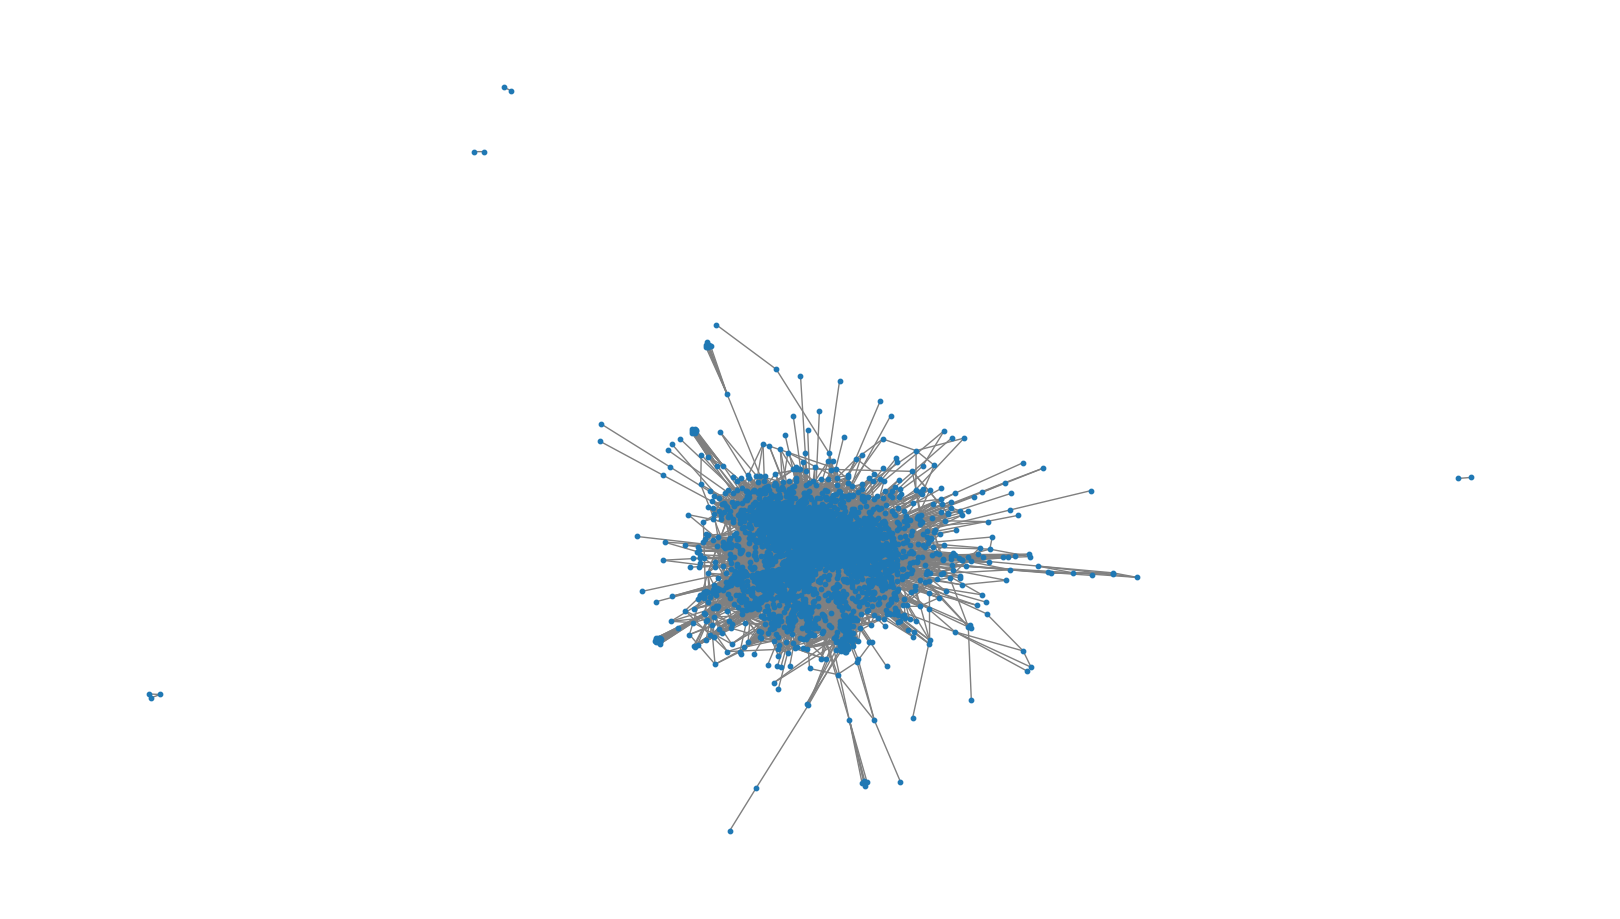

In [61]:
from math import sqrt
count = strong_G.number_of_nodes()
equilibrium = 10 / sqrt(count)    # default for this is 1/sqrt(n), but this will 'blow out' the layout for better visibility
pos = nx.fruchterman_reingold_layout(strong_G, k=equilibrium, iterations=300)
nx.draw(strong_G, pos=pos, node_size=10, edge_color='gray')

Of course, we can specify the layout we want to use, change colours, sizes, etc. The following cell adds the text of the tweets - which can make the layout hard to read.

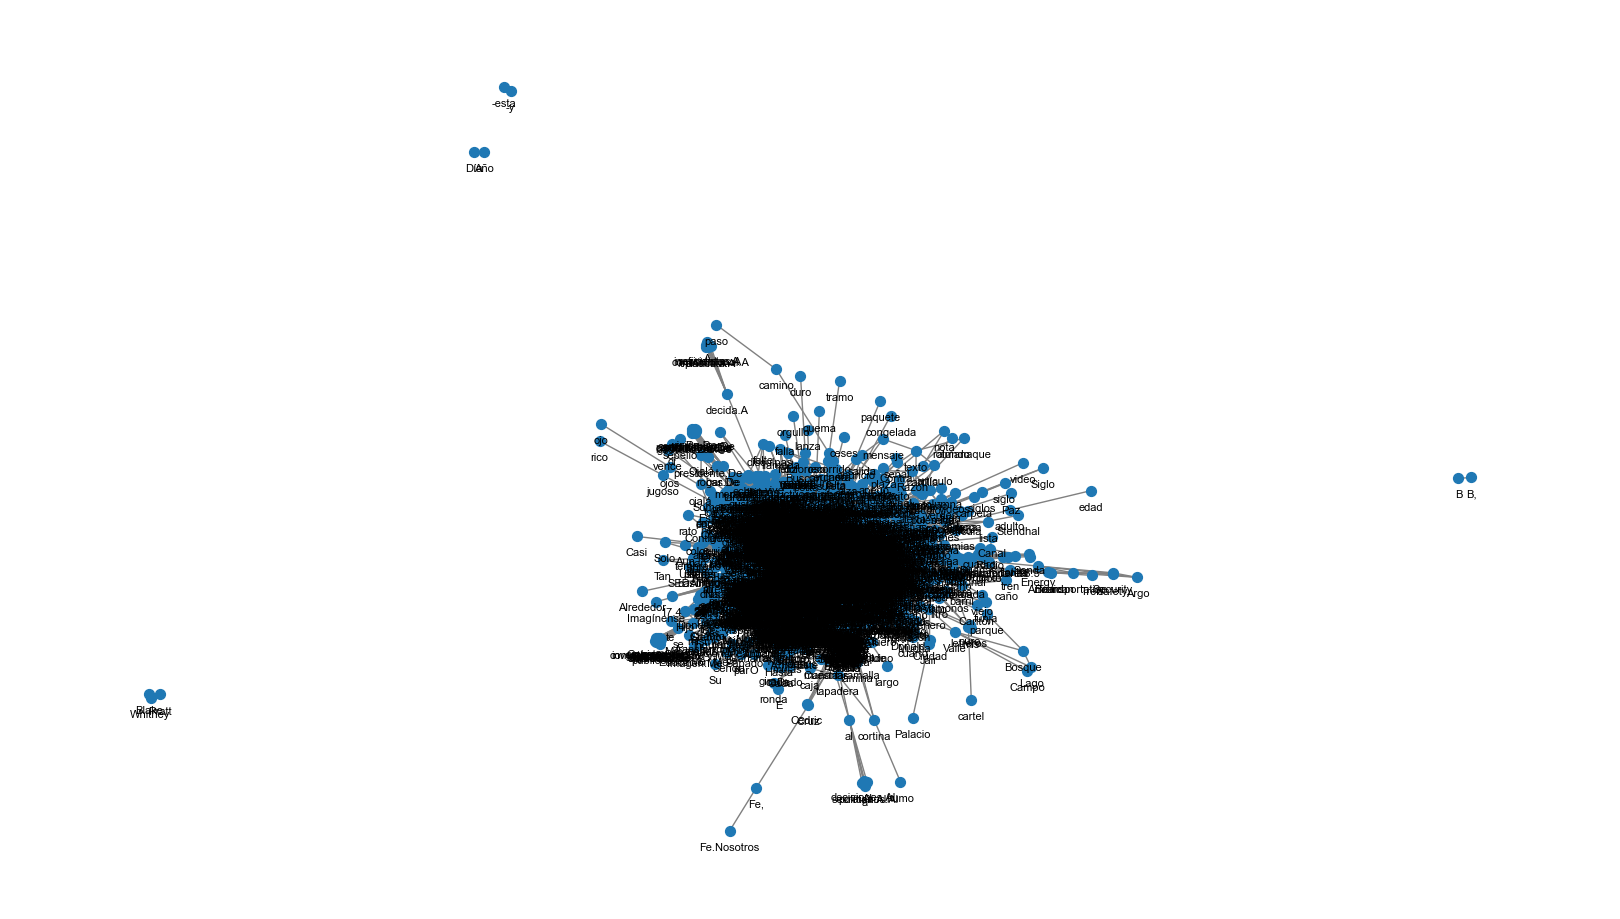

In [62]:
plt.rcParams['figure.figsize'] = [16, 9]  # a better aspect ratio for labelled nodes

nx.draw(strong_G, pos, font_size=3, node_size=50, edge_color='gray', with_labels=False)
for p in pos:  # raise positions of the labels, relative to the nodes
    pos[p][1] -= 0.03
nx.draw_networkx_labels(strong_G, pos, font_size=8, font_color='k')

plt.show()

# Graph Measures

## Page Rank

In [64]:
# the most influential characters
response = nx.pagerank(strong_G)
sorted_pagerank = sorted(response.items(), key=lambda x: x[1], reverse=True)
for character, score in sorted_pagerank[:10]:
    print(character, score)

particular.Entonces, 0.0003728033126253443
considerando, 0.0003727369010571852
corriente.Afortunadamente, 0.00037199593513776325
dependencia.Entonces, 0.00037173960991656154
instituciones.Entonces, 0.00036756352347599677
políticos.Obviamente, 0.00036720985233763083
comunicación, 0.0003610775695835472
ciudadanos.Entonces, 0.00036073543779673424
evaluación, 0.00035996184524696764
claridad.Entonces, 0.0003598278480232829


## Betweenness centrality

In [66]:
# RANKED OUTPUT
response = nx.betweenness_centrality(strong_G)

sorted_bw = sorted(response.items(), key=lambda x: x[1], reverse=True)
for character, score in sorted_bw[:10]:
    print(character, score)

KeyboardInterrupt: 

## Closeness centrality

In [ ]:
# RANKED
response = nx.closeness_centrality(strong_G)

sorted_cc = sorted(response.items(), key=lambda x: x[1], reverse=True)
for character, score in sorted_cc[:10]:
    print(character, score)

# 2. Community Detection Algoritms
## Label Propagation

In [ ]:
communities = nx.label_propagation_communities(G)
sorted_communities = sorted(communities, key=lambda x: len(x), reverse=True)
for community in sorted_communities[:10]:
    print(list(community)[:10])

## Clustering

In [ ]:
response = nx.clustering(strong_G)

biggest_coefficient = sorted(response.items(), key=lambda x: x[1], reverse=True)
for character in biggest_coefficient[:10]:
    print(list(character)[:10])

In [ ]:
list(nx.connected_components(strong_G))

In [ ]:
nx.number_connected_components(strong_G)

In [ ]:
nx.triangles(strong_G) #RAW OUTPUT

Save Graph

In [63]:
import pickle

# save graph object to file
pickle.dump(raw_G, open(f'raw_G_{year_label}.pickle', 'wb'))
pickle.dump(strong_G, open(f'strong_G_{year_label}.pickle', 'wb'))

In [ ]:
# To open the network
G = pickle.load(open(f'strong_G_{year_label}.pickle', 'rb'))